In [2]:
from openmm import app
import openmm as mm
from simtk import unit
from sys import stdout

# Load the PDB file into an object
pdb = app.PDBFile('trpcage.pdb')

# Load the force field file into an object
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

# Create system object using information in the force field:
# forcefield: contains parameters of interactions
# topology: lists of atoms, residues, and bonds
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds, rigidWater=True, 
    ewaldErrorTolerance=0.0005)

# Create a Langevin integrator for temperature control
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)

# Add a Monte Carlo barostat to the system for pressure control
system.addForce(mm.MonteCarloBarostat(1*unit.atmospheres, 300*unit.kelvin, 25))

# Use the CPU platform
platform = mm.Platform.getPlatformByName('CPU')

### If you want to add any forces to your System or modify any
### of the existing forces, you should do it here - after the
### System has been created, but before the Simulation is created.

# Create a Simulation object by putting together the objects above
simulation = app.Simulation(pdb.topology, system, integrator, platform)

# Set positions in the Simulation object
simulation.context.setPositions(pdb.positions)

# Minimize the energy of the system (intentionally doing a rough minimization)
print('Minimizing...')
simulation.minimizeEnergy(maxIterations=20, tolerance=100)

# Initialize the random velocities of the system from a Maxwell-Boltzmann distribution
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

# *Incredibly Short* NPT equilibration (5 ps)
# First, add reporters to the simulation object, which do things at regular intervals
# while the simulation is running. This reporter prints information to the terminal.
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True,
    potentialEnergy=True, temperature=True, density=True, progress=True,
    remainingTime=True, speed=True, totalSteps=2500, separator='\t'))
# Next, run the equilibration simulation itself.
print('Running Equilibration...')
simulation.step(2500)

# Production (40 ps)
# Before doing anything, remember to clear the previous reporters. In the code below
# the first reporter creates a DCD trajectory file. The second reporter is otherwise
# very similar to the one above in the equilibration section. The only difference --
# other than ouput frequency -- is that the totalSteps parameter is modified to be
# the number of production steps + equilibration steps. Run the code to see why...
# A: Christian Bale
simulation.reporters.clear()
simulation.reporters.append(app.DCDReporter('trajectory.dcd', 100))
simulation.reporters.append(app.StateDataReporter(stdout, 500, step=True, 
    potentialEnergy=True, temperature=True, density=True, progress=True, 
    remainingTime=True, speed=True, totalSteps=22500, separator='\t'))
# Run the production simulation!
print('Running Production...')
simulation.step(20000)
print('Done!')


Minimizing...
Running Equilibration...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"	"Speed (ns/day)"	"Time Remaining"
4.0%	100	-29516.99445771337	256.40294681867306	0.9011250611450068	0	--
8.0%	200	-29341.976483745977	264.02882861695235	0.9035609435415863	66	0:06
12.0%	300	-29533.021876700495	278.5180134458503	0.9067091024460789	65.7	0:05
16.0%	400	-29500.2596418997	278.2538020480517	0.9211677302963716	64.9	0:05
20.0%	500	-29531.38484170761	288.95492553822345	0.9302450692004786	63.5	0:05
24.0%	600	-29411.296371559343	284.18895846690015	0.9329500871873271	61.1	0:05
28.0%	700	-29478.14531004107	284.49160269051157	0.9429810804910475	60.3	0:05
32.0%	800	-29438.970353645345	287.10929075650125	0.9563025778783268	60.1	0:04
36.0%	900	-29592.53796448491	295.5442498626587	0.9618542966046456	60	0:04
40.0%	1000	-29817.05365912411	309.96075195969246	0.97083702487461	60.1	0:04
44.0%	1100	-29854.50162961588	306.4252658856307	0.9812723860981322	60	0:04
48.0%	1

In [4]:
import mdtraj as md
import nglview as nv

In [11]:
traj = md.load('trajectory.dcd', top='trpcage.pdb')
view.add_representation(repr_type='surface', selection='X.CA or Y.CA', surfaceType='vws')
view.add_distance(atom_pair=[['X.CA', 'Y.CA']], label_color='black')
viewsim = nv.show_mdtraj(traj)
viewsim

NGLWidget(max_frame=199)

In [12]:
from openmm import app
import openmm as mm
from simtk import unit
from sys import stdout

In [28]:
# Load the PDB file into an object
pdb = app.PDBFile('trpcage.pdb')

# Load the force field file into an object
forcefield = app.ForceField('amber99sbildn.xml', 'tip3p.xml')

# Create system object using information in the force field:
# forcefield: contains parameters of interactions
# topology: lists of atoms, residues, and bonds
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds, rigidWater=True, 
    ewaldErrorTolerance=0.0005)

# Create a Langevin integrator for temperature control
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)

# Add a Monte Carlo barostat to the system for pressure control
system.addForce(mm.MonteCarloBarostat(1*unit.atmospheres, 300*unit.kelvin, 25))

# Use the CPU platform
platform = mm.Platform.getPlatformByName('CPU')

In [29]:
## Add forces between sytem setup and simulation 
 
frc = mm.CustomBondForce("0.5*k*(r-r0)^2")
frc.addGlobalParameter("k", 10000)
frc.addGlobalParameter("r0", 2)

frc.addBond(56, 200)
system.addForce(frc)

# Create a Simulation object using definitions from above
simulation = app.Simulation(pdb.topology, system, integrator, platform)

# Set positions in the Simulation object
simulation.context.setPositions(pdb.positions)

# Minimize the energy of the system
print('Minimizing...')
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())
simulation.minimizeEnergy(maxIterations=20, tolerance=100)
print(simulation.context.getState(getEnergy=True).getPotentialEnergy())

# Initialize the random velocities of the system from a Maxwell-Boltzmann distribution
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

# Create .dcd traj file
simulation.reporters.append(app.DCDReporter('trajectory-spr.dcd', 100))

# Report information as simulation runs
simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True,
    potentialEnergy=True, temperature=True, density=True, progress=True,
    remainingTime=True, speed=True, totalSteps=10000, separator='\t'))

# Run simulation
print('Running Production...')
simulation.step(10000)
print('Done!')

Minimizing...
-21814.454368745173 kJ/mol
-29477.083367484734 kJ/mol
Running Production...
#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Density (g/mL)"	"Speed (ns/day)"	"Time Remaining"
1.0%	100	-29043.555968019202	294.35070031510514	0.8997159120677996	0	--
2.0%	200	-29129.375995649985	295.8761282705436	0.904113762577902	58.6	0:28
3.0%	300	-29072.19240363928	295.4594136743788	0.910416049934108	56.9	0:29
4.0%	400	-29120.835306650937	295.9475447548905	0.9254983784127089	54.8	0:30
5.0%	500	-29198.601848281538	295.5312631242103	0.9335108181014954	54.3	0:30
6.0%	600	-29324.424523349677	293.7431600975889	0.9430683914643364	54.4	0:29
7.0%	700	-29320.312636921983	301.68625656220433	0.9448052044127783	54.4	0:29
8.0%	800	-29126.63711374716	293.4027354830854	0.9491560654952542	54.5	0:29
9.0%	900	-29303.24087323083	290.2383508639769	0.9576405074022737	54.9	0:28
10.0%	1000	-29559.004503517997	298.49191895634937	0.9806550692661513	54.9	0:28
11.0%	1100	-29382.761929733228	292

In [44]:
traj = md.load('trajectory-spr.dcd', top='trpcage.pdb')
viewsim = nv.show_mdtraj(traj)
viewsim

NGLWidget(max_frame=99)

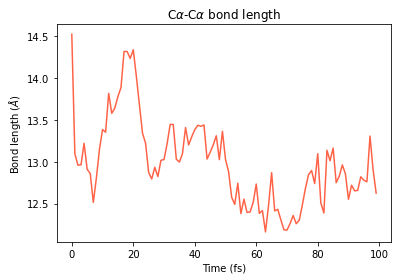

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

traj = md.load('trajectory-spr.dcd', top='trpcage.pdb')

bond_indices = [56, 200]
Calength = md.compute_distances(traj, [bond_indices])


plt.plot(10*Calength, color='Tomato')
# note above that we have multiplied NClength by 10 to convert from nm to Å
plt.title(r'C$\alpha$-C$\alpha$ bond length')
plt.xlabel('Time (fs)')
plt.ylabel(r'Bond length ($\AA$)')
plt.show()